# EMODnet data

So far we have only run queries against the VOTO ERDDAP. This notebook demonstrates some datasets from the [EMODnet ERDDAP](https://erddap.emodnet-physics.eu/erddap/info/index.html).

In [1]:
from erddapy import ERDDAP
import json
import xarray as xr
import matplotlib.pyplot as plt

### Specify server and protocol

We will start with tabledap data. These datasets are timeseries, like the glider we have worked with so far

We will first use an arice dataset from the EMODnet ERDDAP

In [2]:
e = ERDDAP(
    server="https://erddap.emodnet-physics.eu/erddap",
    protocol="tabledap",
)

In [3]:
e.dataset_id="ARICE_de_pangaea_dataset326625"
ds_arice = e.to_xarray()

/home/callum/anaconda3/envs/erddapdemo/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'Visib' has multiple fill values {9.969209968386869e+36, 9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
ds_arice

<xarray.Dataset>
Dimensions:      (row: 3308)
Coordinates:
    altitude     (row) float64 ...
    time         (row) datetime64[ns] ...
    latitude     (row) float64 ...
    longitude    (row) float64 ...
Dimensions without coordinates: row
Data variables: (12/20)
    Ceil         (row) float32 ...
    Course       (row) float64 ...
    Bathy_depth  (row) float64 ...
    TdTdTd       (row) float64 ...
    Elevation    (row) float64 ...
    Head         (row) float64 ...
    ...           ...
    Visib        (row) float64 ...
    RelWindDir   (row) float64 ...
    dd           (row) float64 ...
    RelWindGust  (row) float64 ...
    RelWindSp    (row) float64 ...
    ff           (row) float64 ...
Attributes: (12/43)
    authors:                       König-Langlo, Gert
    cdm_data_type:                 Point
    citation:                      König-Langlo, Gert (2005): Continuous mete...
    contact:                       gert.koenig-langlo@awi.de
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    dataset:                       de.pangaea.dataset326625
    ...                            ...
    time_coverage_end:             2001-05-06T23:55:00Z
    time_coverage_start:           2001-04-14T00:05:00Z
    title:                         Continuous meteorological surface measurem...
    uuid:                          de.pangaea.dataset326625
    Westernmost_Easting:           -86.4635
    year:                          2005

In [5]:
ds_arice.attrs["citation"]

'König-Langlo, Gert (2005): Continuous meteorological surface measurement during POLARSTERN cruise ANT-XVIII/5b. Alfred Wegener Institute, Helmholtz Centre for Polar and Marine Research, Bremerhaven, PANGAEA, https://doi.org/10.1594/PANGAEA.326625'

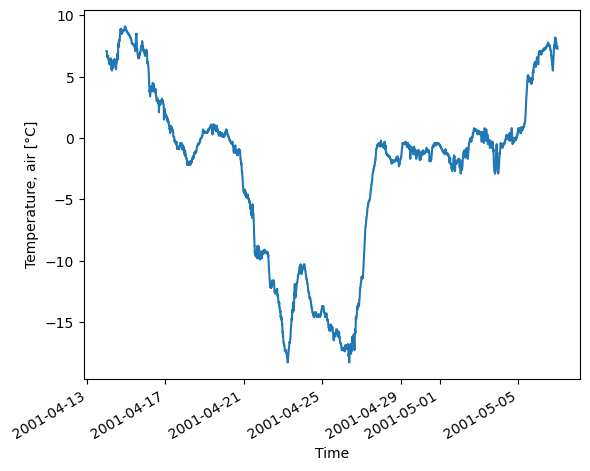

In [6]:
ds_arice.TTT.plot(x="time")

### Gridded data

ERDDAP has a seperate mechanism for gridded data, like satellite and model/reanalysis products. This is called griddap. 

In [7]:
e = ERDDAP(
    server="https://erddap.emodnet-physics.eu/erddap",
    protocol="griddap",
)
e.dataset_id="SMOS_SSS_L3_V2020"

e.griddap_initialize() # This sends a background request to find the dataset's variables and extent

print(f"variables in this dataset:\n\n{e.variables}")


variables in this dataset:

['uncertainty_sss', 'hr_sss', 'lr_sss']


In [8]:
ds_sss = e.to_xarray()

In [9]:
ds_sss

<xarray.Dataset>
Dimensions:          (time: 1, latitude: 720, longitude: 1440)
Coordinates:
  * time             (time) datetime64[ns] 2021-05-24T23:00:00
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    uncertainty_sss  (time, latitude, longitude) float32 ...
    hr_sss           (time, latitude, longitude) float32 ...
    lr_sss           (time, latitude, longitude) float32 ...
Attributes: (12/51)
    Acknowledgement:                           A complete description of the ...
    cdm_data_type:                             Grid
    comment:                                   These data were produced at BE...
    Conventions:                               CF-1.6, COARDS, ACDD-1.3
    copyright:                                 BEC research products are free...
    creator_email:                             olmedo@icm.csic.es
    ...                                        ...
    time_coverage_end:                         2021-05-24T23:00:00Z
    time_coverage_start:                       2021-05-24T23:00:00Z
    title:                                     SMOS BEC global SSS product v2...
    url:                                       http://bec.icm.csic.es
    Westernmost_Easting:                       -179.875
    wms_getcapabilities:                       https://erddap.emodnet-physics...

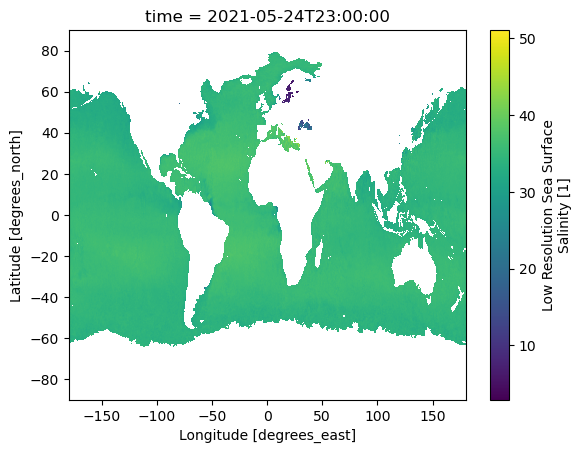

In [10]:
ds_sss.lr_sss.plot();

Gridded datasets can be very large. By default, erddapy returns only the most recent time slice of a dataset. This behaviour can be changed by adjusting the constraints.

The mechanism for subsetting griddap data is a little more complicated, as the data are multi-dimensional.

Let's zoom in on the North Sea/Baltic and take a few time slices

In [11]:
e.constraints

{'time>=': '2021-05-24T23:00:00Z',
 'time<=': '2021-05-24T23:00:00Z',
 'time_step': 1,
 'latitude>=': -89.875,
 'latitude<=': 89.875,
 'latitude_step': 1,
 'longitude>=': -179.875,
 'longitude<=': 179.875,
 'longitude_step': 1}

To achieve this, we modify the constraints. We will tighten the lon/lat to a window of interest and request a wider timespan of data, taking every 30th day over the last few years

In [12]:
e.constraints = {'time>=': '2018-05-24T23:00:00Z',
 'time<=': '2021-05-24T23:00:00Z',
 'time_step': 30,
 'latitude>=': 50,
 'latitude<=': 70,
 'latitude_step': 1,
 'longitude>=': -10,
 'longitude<=': 30,
 'longitude_step': 1}

ds_sss_baltic = e.to_xarray()

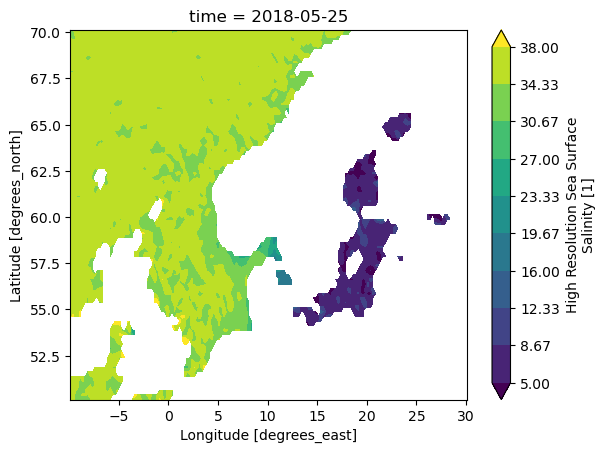

In [13]:
xr.plot.contourf(ds_sss_baltic.sel(time="'2018-06-01", method="nearest").hr_sss, vmin=5, vmax=38, levels=10);

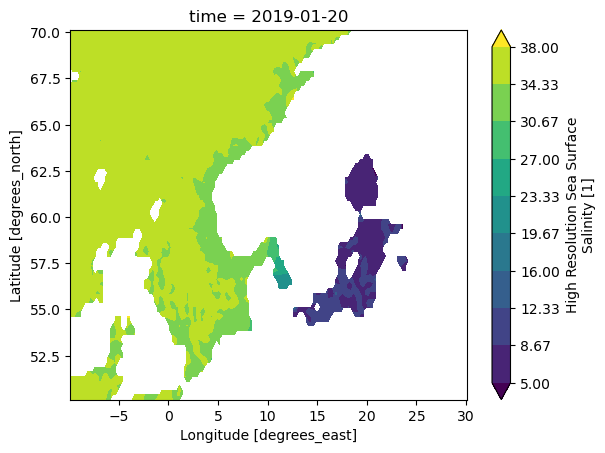

In [14]:
xr.plot.contourf(ds_sss_baltic.sel(time="'2019-02-01", method="nearest").hr_sss, vmin=5, vmax=38, levels=10);

----------------------------

### References

EMODnet ERDDAP https://erddap.emodnet-physics.eu/erddap/info/index.html

For more information on how erddapy deals with griddap, see the [erddapy documentation example notebook](https://ioos.github.io/erddapy/01a-griddap-output.html)